In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a04Fd.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/13b02Fb.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09b01Wb.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a01Wa.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/14a05Wa.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/03a05Aa.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/11a04Wc.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09a05Tb.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12a01Wc.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12a04Wc.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09a04La.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/08b02Nb.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12b10Wa.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a0

In [18]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
import librosa
import numpy as np
import pandas as pd


In [19]:
tf.random.set_seed(42)

# Paths to datasets
BerlinDB = "/kaggle/input/berlin-database-of-emotional-speech-emodb"
Tess_path = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"



In [20]:
# Load EmoDB dataset
berlin_directory_list = os.listdir(BerlinDB)

file_emotion = []
file_path = []

for dir in berlin_directory_list:
    directories = os.listdir(BerlinDB + "/" + dir)
    
    for file in directories:
        file_path.append(BerlinDB + "/wav/" +file)
        part = file.split(".")[0]
        ele = part[5]
        if ele=='W':
            file_emotion.append('angry')
        elif ele=='E':
            file_emotion.append('disgust')
        elif ele=='A':
            file_emotion.append('fear')
        elif ele=='F':
            file_emotion.append('happy')
        elif ele=='N':
            file_emotion.append('neutral')
        elif ele=='T':
            file_emotion.append('sad')
        else:
            file_emotion.append('boredom')

# DataFrame for EmoDB
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Berlin_df = pd.concat([emotion_df, path_df], axis=1)



In [21]:
# Load TESS dataset
Tess_dir_list = os.listdir(Tess_path)
emotions_tess = []
path_tess = []

for it in Tess_dir_list:
    directories = os.listdir(Tess_path + '/' + it)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            emotions_tess.append('surprise')
        else:
            emotions_tess.append(part)
        path_tess.append(Tess_path + it + '/' + file)
        
# DataFrame for TESS
emotion_tess_df = pd.DataFrame(emotions_tess, columns=['Emotions'])
path_tess_df = pd.DataFrame(path_tess, columns=['Path'])
Tess_df = pd.concat([emotion_tess_df, path_tess_df], axis=1)



In [22]:
# Combine datasets
combined_df = pd.concat([Berlin_df, Tess_df], ignore_index=True)



In [23]:
# Display the combined DataFrame
combined_df.head()


,Emotions,Path
0,happy,/kaggle/input/berlin-database-of-emotional-spe...
1,happy,/kaggle/input/berlin-database-of-emotional-spe...
2,angry,/kaggle/input/berlin-database-of-emotional-spe...
3,angry,/kaggle/input/berlin-database-of-emotional-spe...
4,angry,/kaggle/input/berlin-database-of-emotional-spe...


In [24]:
combined_df['Emotions'].value_counts()

Emotions
angry       527
neutral     479
happy       471
fear        469
sad         462
disgust     446
surprise    400
boredom      81
Name: count, dtype: int64

In [25]:
# Remove 'boredom' values
combined_df = combined_df[combined_df['Emotions'] != 'boredom']

In [26]:
# Function to sample 400 values per emotion
def balance_emotions(df, num_samples=400):
    balanced_df = pd.DataFrame(columns=df.columns)
    for emotion in df['Emotions'].unique():
        emotion_df = df[df['Emotions'] == emotion]
        if len(emotion_df) >= num_samples:
            sampled_df = emotion_df.sample(n=num_samples, random_state=42)
        else:
            sampled_df = emotion_df
        balanced_df = pd.concat([balanced_df, sampled_df])
    return balanced_df



In [27]:
# Balance the DataFrame
balanced_df = balance_emotions(combined_df)

# Shuffle the DataFrame to mix the samples
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [28]:
# Display the value counts to verify
print(balanced_df['Emotions'].value_counts())


Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


In [29]:
balanced_df.head()

,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,angry,/kaggle/input/toronto-emotional-speech-set-tes...
2,disgust,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,neutral,/kaggle/input/toronto-emotional-speech-set-tes...


DATA PREPROCESSING


In [41]:
data,sr = librosa.load(path_tess[0])
sr

22050

In [37]:
# Preprocessing function
def preprocess_audio(data, sampling_rate):
    data = librosa.util.normalize(data)
    data, _ = librosa.effects.trim(data)
    target_length = 5 * sampling_rate
    if len(data) > target_length:
        data = data[:target_length]
    else:
        padding = target_length - len(data)
        data = np.pad(data, (0, padding), 'constant', constant_values=(0, 0))
    return data

In [42]:
# Determine the sampling rate (adjust if needed)
sampling_rate = 22050  # Example: 16kHz

# Preprocess the audio files and create a new DataFrame
preprocessed_data = []

for index, row in balanced_df.iterrows():
    file_path = row['Path']
    data, sr = librosa.load(file_path, sr=sampling_rate)
    preprocessed_audio = preprocess_audio(data, sampling_rate)
    preprocessed_data.append((row['Emotions'], preprocessed_audio))

# Create a new DataFrame with preprocessed audio data
preprocessed_balanced_df = pd.DataFrame(preprocessed_data, columns=['Emotions', 'Preprocessed_Audio'])

# Display the first few rows of the new DataFrame
print(preprocessed_balanced_df.head())

  Emotions                                 Preprocessed_Audio
0     fear  [0.00082180504, -0.00086802617, -0.005306665, ...
1    angry  [0.000996878, 0.00030024984, -0.0010029378, -0...
2  disgust  [-5.1529114e-05, 0.00066108146, 0.0005297141, ...
3     fear  [2.1297714e-05, -0.0002564254, -0.00071632647,...
4  neutral  [-1.0703065e-05, 1.0001933e-05, -4.3388513e-06...


In [47]:
# Feature extraction function (updated)
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)  # Ensuring consistent sampling rate
    y = preprocess_audio(y, sr)  # Preprocess audio data
    
    # Extract MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)
    
    # Extract Mel Spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    mel = np.mean(mel.T, axis=0)
    
    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma = np.mean(chroma.T, axis=0)
    
    # Combine features
    features = np.hstack([mfccs, mel, chroma])
    
    return features

In [48]:
# Extract features for each audio file and create a new DataFrame
extracted_features = []

for index, row in balanced_df.iterrows():
    file_path = row['Path']
    features = extract_features(file_path)
    extracted_features.append((row['Emotions'], features))

# Dynamically generate feature column names
sample_features = extract_features(balanced_df.iloc[0]['Path'])
n_mfcc = 40
n_mel = len(sample_features) - n_mfcc - 12  # Adjusting for 12 Chroma features
feature_columns = [f'mfcc_{i}' for i in range(1, n_mfcc + 1)] + [f'mel_{i}' for i in range(1, n_mel + 1)] + [f'chroma_{i}' for i in range(1, 13)]

# Ensure extracted_features is formatted correctly for DataFrame construction
formatted_features = [(emotion, *features) for emotion, features in extracted_features]

# Create a new DataFrame with extracted features
features_df = pd.DataFrame(formatted_features, columns=['Emotions'] + feature_columns)

# Display the first few rows of the new DataFrame with features
print(features_df.head())

  Emotions      mfcc_1     mfcc_2     mfcc_3    mfcc_4     mfcc_5    mfcc_6  \
0     fear -415.914368   6.311338  -4.463645  1.527133  -3.374936  3.389641   
1    angry -437.419800  11.636627  -0.540993  1.490634 -12.068159  2.187778   
2  disgust -391.835999  45.110043  10.156169  0.295602   5.434726 -5.954273   
3     fear -412.275879  18.174234  -0.916264 -5.185453   0.361099 -1.557661   
4  neutral -382.300842  27.075190   7.500626  9.032352   1.960893  0.506844   

     mfcc_7    mfcc_8    mfcc_9  ...  chroma_3  chroma_4  chroma_5  chroma_6  \
0 -2.057870 -2.481449  1.936391  ...  0.127963  0.104567  0.079003  0.084961   
1 -8.677585 -2.244958 -4.079091  ...  0.109137  0.101180  0.103828  0.135479   
2 -2.096240 -6.718378 -3.978937  ...  0.181677  0.201631  0.192908  0.223932   
3 -2.336267 -3.249988 -3.820262  ...  0.152343  0.235561  0.121550  0.047792   
4 -1.546114 -3.693655 -5.400360  ...  0.060696  0.057737  0.074872  0.180415   

   chroma_7  chroma_8  chroma_9  chroma_10  

In [ ]:
features_df

In [49]:
# Encode labels
label_encoder = LabelEncoder()
features_df['Emotions'] = label_encoder.fit_transform(features_df['Emotions'])

# Split data
X = features_df.drop(['Emotions'], axis=1).values
y = to_categorical(features_df['Emotions'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Reshape data for CNN + LSTM model
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Build the CNN + LSTM model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model with the checkpoint callback
history = model.fit(X_train, y_train, epochs=110, batch_size=32, validation_split=0.2, verbose=1, callbacks=[checkpoint_callback])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Load the best weights
model.load_weights('best_model.keras')

# Save the final model with the best weights
model.save('speech_emotion_recognition_model2.keras')


Epoch 1/110


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1759 - loss: 1.9230
Epoch 1: val_accuracy improved from -inf to 0.33705, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1788 - loss: 1.9202 - val_accuracy: 0.3371 - val_loss: 1.6922
Epoch 2/110
52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3126 - loss: 1.6878
Epoch 2: val_accuracy improved from 0.33705 to 0.34821, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3112 - loss: 1.6878 - val_accuracy: 0.3482 - val_loss: 1.5924
Epoch 3/110
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2973 - loss: 1.6756
Epoch 3: val_accuracy improved from 0.34821 to 0.38616, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2975 - loss: 1.6751 - val_accuracy: 0.3862 - val_loss: 1.4961
Epoch 4/110
52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3938 - loss: 1.4950
Epoch 4: val_accuracy did not improve from 0.38616
56/56

In [51]:
import matplotlib.pyplot as plt

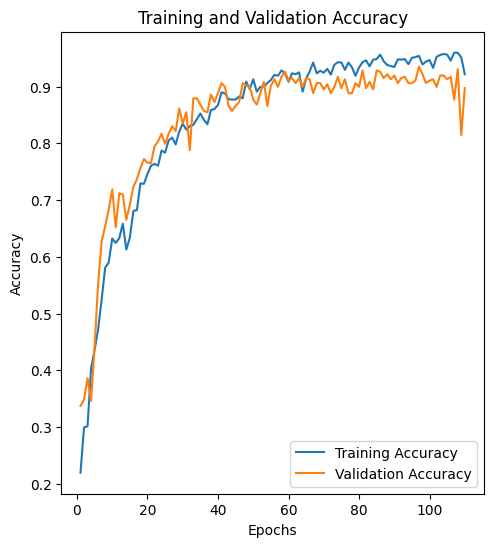

In [52]:
# Extract accuracy and loss values from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

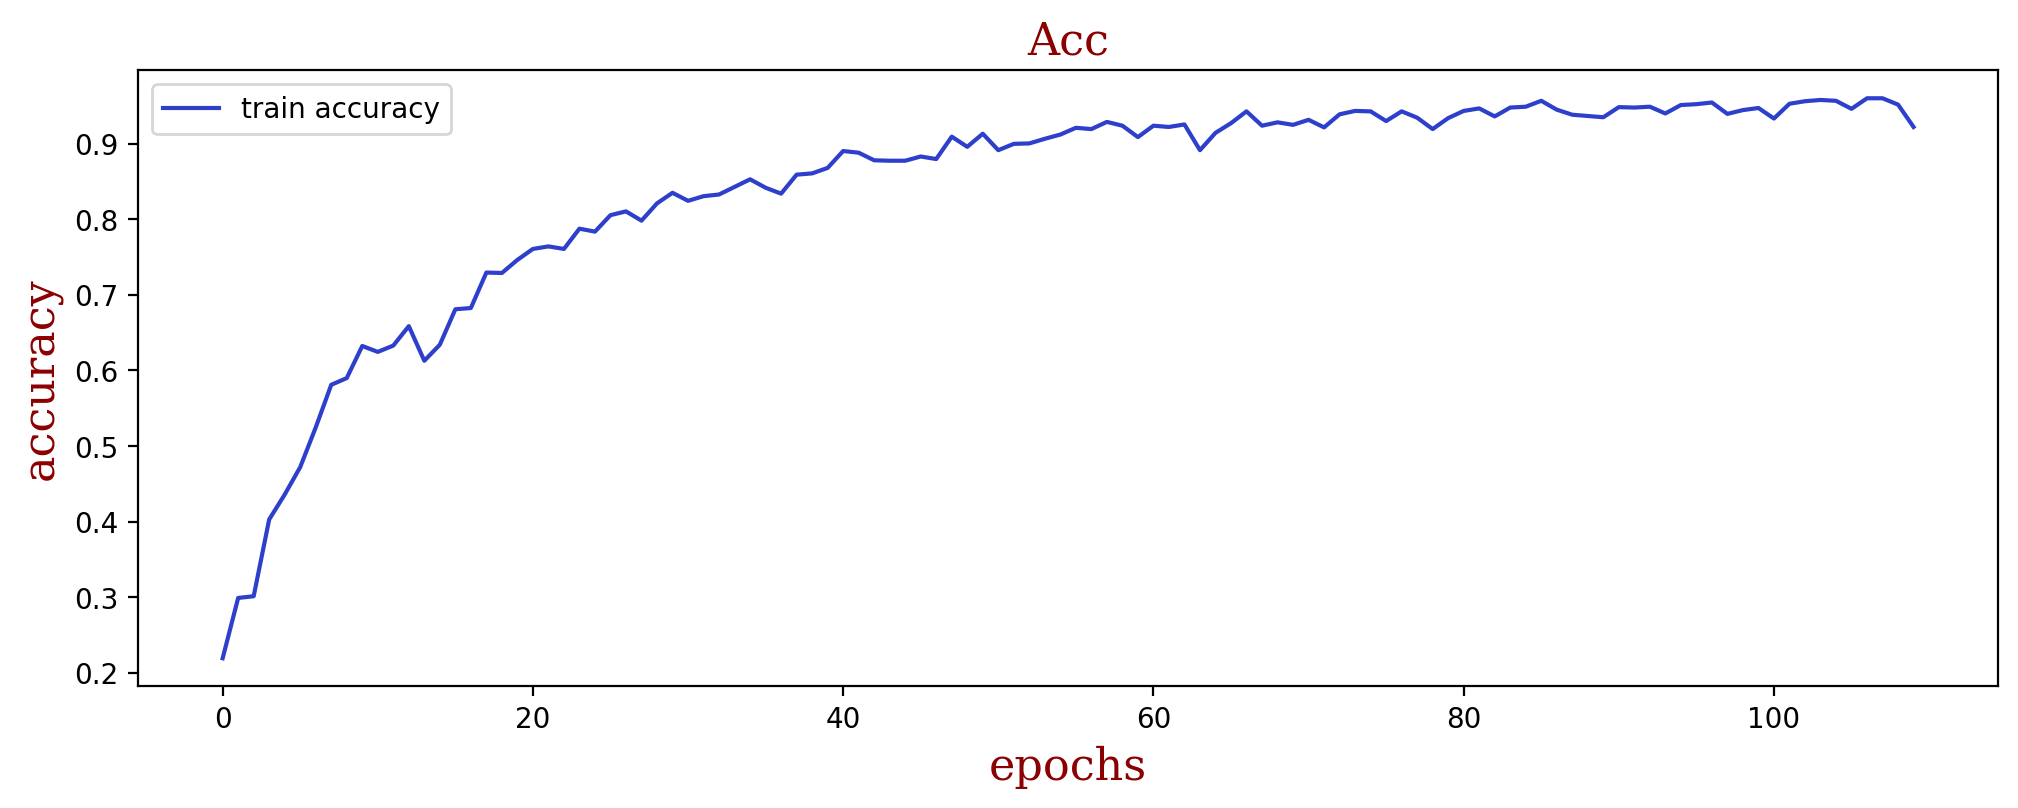

In [53]:
epochs = list(range(110))
acc = history.history['accuracy']
font2 = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16}

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, acc, label='train accuracy', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('accuracy', fontdict= font2)
plt.title('Acc', fontdict= font2)
plt.legend()
plt.show()

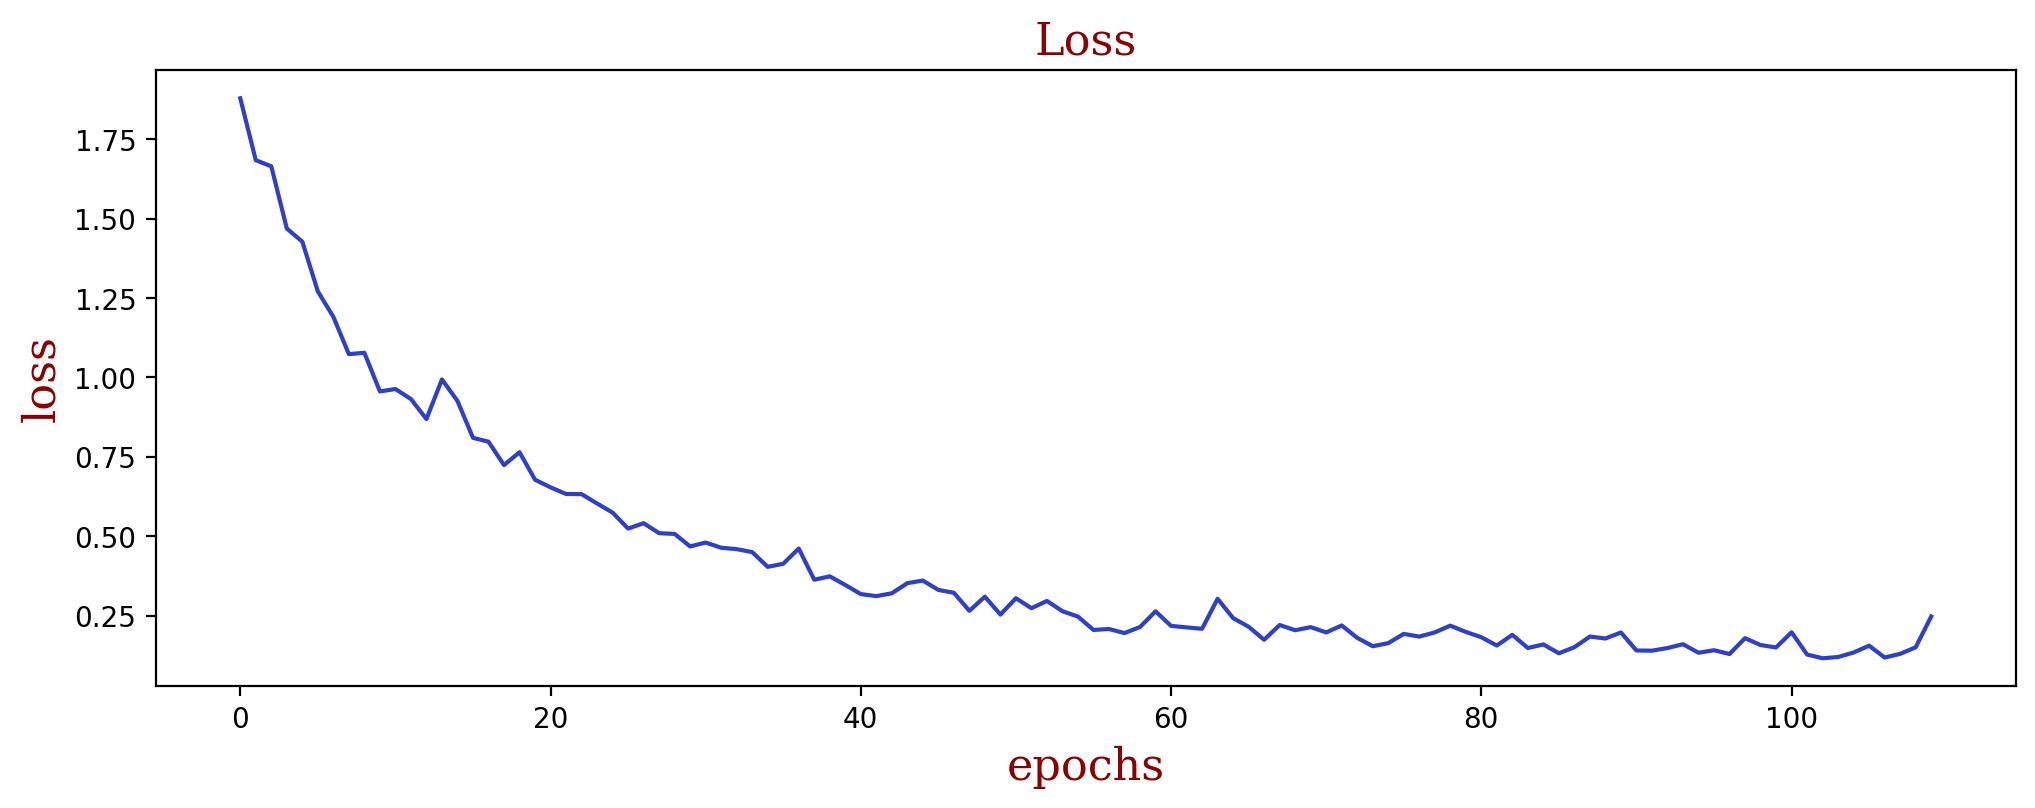

In [54]:
loss = history.history['loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, loss, label='train loss', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('loss', fontdict= font2)
plt.title('Loss', fontdict= font2)
plt.show()

In [55]:
# Predict on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([3, 0, 0, 2, 6, 0, 4, 3, 4, 2, 2, 3, 5, 1, 3, 0, 5, 0, 1, 4, 3, 3,
       2, 5, 6, 3, 0, 5, 2, 6, 3, 0, 4, 6, 4, 5, 5, 3, 3, 4, 0, 2, 2, 1,
       6, 0, 6, 6, 3, 5, 6, 6, 3, 2, 4, 3, 1, 0, 0, 3, 1, 4, 5, 4, 1, 3,
       3, 0, 2, 4, 3, 6, 1, 6, 4, 4, 4, 1, 0, 5, 2, 4, 0, 2, 2, 4, 0, 2,
       1, 4, 5, 1, 5, 0, 4, 3, 4, 6, 3, 3, 4, 2, 6, 1, 1, 2, 2, 4, 2, 0,
       4, 4, 0, 2, 0, 3, 5, 0, 5, 1, 5, 0, 0, 4, 0, 2, 2, 5, 5, 2, 1, 4,
       6, 1, 6, 6, 6, 1, 6, 2, 0, 1, 0, 2, 0, 3, 5, 6, 4, 0, 2, 0, 5, 0,
       2, 4, 3, 3, 3, 4, 4, 4, 1, 4, 4, 4, 5, 5, 6, 0, 4, 5, 3, 2, 6, 3,
       4, 1, 4, 1, 2, 3, 5, 0, 5, 3, 3, 2, 6, 3, 1, 1, 6, 4, 4, 2, 5, 2,
       1, 6, 5, 3, 6, 5, 6, 0, 6, 5, 3, 0, 2, 6, 0, 0, 0, 4, 5, 1, 4, 5,
       6, 1, 2, 5, 6, 5, 0, 4, 3, 5, 2, 2, 1, 2, 1, 3, 6, 4, 6, 2, 6, 1,
       4, 2, 2, 3, 6, 3, 6, 0, 0, 4, 1, 6, 6, 2, 6, 5, 3, 3, 5, 1, 3, 0,
       4, 5, 6, 6, 0, 2, 4, 2, 0, 2, 4, 0, 5, 4, 3, 2, 4, 5, 2, 1, 5, 5,
       3, 3, 4, 6, 5, 0, 0, 5, 3, 1, 5, 3, 1, 4, 2,

In [56]:
# Your true labels for the test set are already 'y_test'
y_true = y_test
# Convert one-hot encoded y_true to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_true_labels

array([3, 0, 0, 2, 6, 0, 4, 3, 5, 2, 2, 3, 5, 1, 3, 0, 5, 0, 1, 4, 3, 3,
       2, 5, 6, 3, 0, 5, 2, 6, 3, 0, 4, 6, 4, 5, 5, 3, 3, 4, 0, 2, 2, 1,
       6, 0, 6, 6, 3, 5, 6, 6, 3, 2, 4, 3, 1, 0, 0, 3, 1, 4, 5, 2, 1, 3,
       3, 0, 2, 4, 3, 6, 1, 6, 4, 4, 4, 1, 0, 5, 2, 4, 0, 1, 2, 4, 0, 2,
       1, 4, 5, 1, 5, 0, 4, 3, 4, 6, 3, 3, 4, 2, 6, 1, 1, 2, 2, 4, 3, 0,
       4, 4, 0, 2, 0, 3, 5, 0, 5, 1, 5, 0, 0, 4, 0, 2, 2, 5, 5, 2, 1, 4,
       6, 1, 6, 6, 6, 1, 1, 2, 0, 1, 0, 0, 0, 3, 5, 6, 1, 0, 2, 0, 5, 0,
       2, 4, 3, 3, 3, 4, 4, 4, 1, 4, 4, 4, 5, 5, 6, 0, 1, 5, 3, 2, 6, 0,
       4, 1, 4, 1, 2, 3, 5, 0, 5, 3, 6, 2, 6, 3, 3, 1, 6, 4, 5, 2, 5, 2,
       1, 6, 5, 3, 6, 5, 6, 0, 6, 5, 3, 0, 2, 6, 0, 0, 0, 4, 5, 1, 4, 5,
       6, 1, 2, 5, 6, 5, 0, 5, 3, 5, 2, 2, 1, 2, 3, 3, 6, 4, 6, 4, 6, 1,
       4, 2, 2, 3, 6, 3, 6, 0, 0, 4, 1, 6, 6, 2, 6, 5, 3, 3, 5, 1, 3, 0,
       4, 5, 6, 1, 3, 2, 4, 2, 0, 2, 4, 0, 5, 4, 3, 2, 4, 5, 2, 1, 5, 5,
       3, 3, 4, 6, 5, 0, 0, 5, 3, 1, 5, 3, 1, 4, 3,

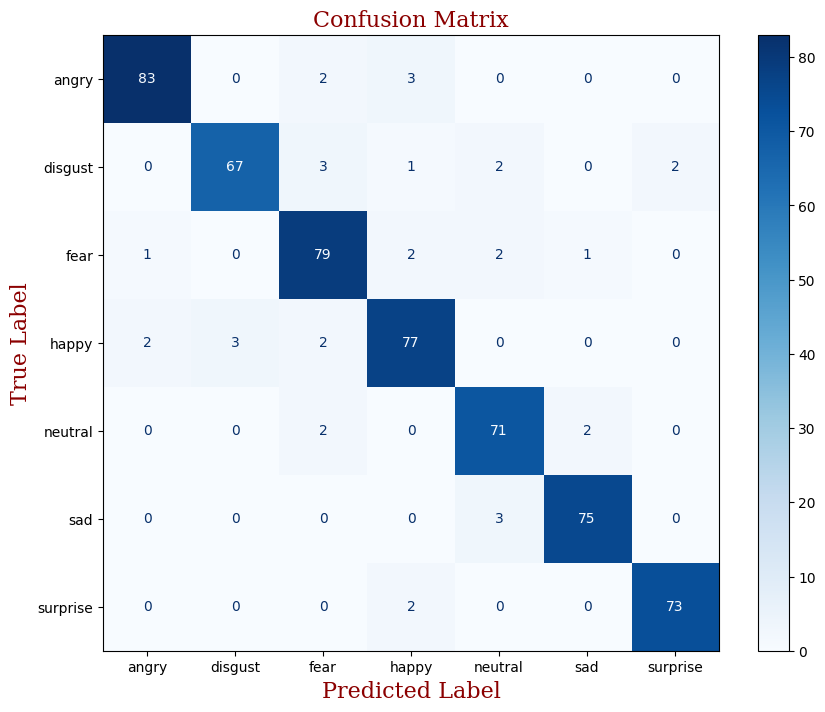

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])  
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.xlabel('Predicted Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.ylabel('True Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.show()


In [58]:
from sklearn.metrics import f1_score

# Assuming y_true_labels and y_pred are already defined
f1 = f1_score(y_true_labels, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
print(f'F1 Score: {f1:.4f}')


F1 Score: 0.9376


In [59]:
from sklearn.metrics import classification_report

report = classification_report(y_true_labels, y_pred, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
print(report)


              precision    recall  f1-score   support

       angry       0.97      0.94      0.95        88
     disgust       0.96      0.89      0.92        75
        fear       0.90      0.93      0.91        85
       happy       0.91      0.92      0.91        84
     neutral       0.91      0.95      0.93        75
         sad       0.96      0.96      0.96        78
    surprise       0.97      0.97      0.97        75

    accuracy                           0.94       560
   macro avg       0.94      0.94      0.94       560
weighted avg       0.94      0.94      0.94       560



Accuracy: 0.9375
Precision: 0.9382
Recall: 0.9375
F1 Score: 0.9376
ROC-AUC Score: 0.9945
              precision    recall  f1-score   support

       angry       0.97      0.94      0.95        88
     disgust       0.96      0.89      0.92        75
        fear       0.90      0.93      0.91        85
       happy       0.91      0.92      0.91        84
     neutral       0.91      0.95      0.93        75
         sad       0.96      0.96      0.96        78
    surprise       0.97      0.97      0.97        75

    accuracy                           0.94       560
   macro avg       0.94      0.94      0.94       560
weighted avg       0.94      0.94      0.94       560



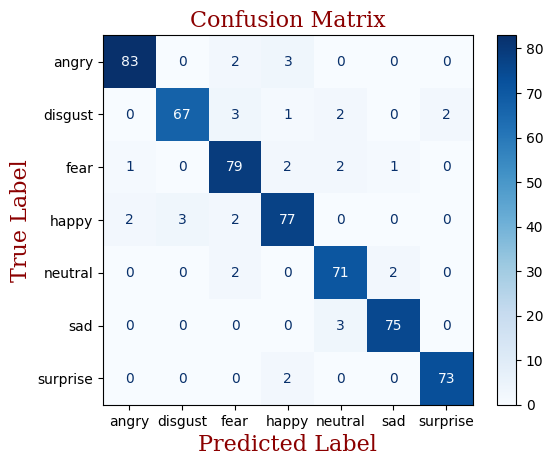

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Calculate metrics
accuracy = accuracy_score(y_true_labels, y_pred)
precision = precision_score(y_true_labels, y_pred, average='weighted')
recall = recall_score(y_true_labels, y_pred, average='weighted')
f1 = f1_score(y_true_labels, y_pred, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# ROC-AUC Score 
roc_auc = roc_auc_score(y_true_labels, y_pred_prob, multi_class='ovr')
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Classification Report
report = classification_report(y_true_labels, y_pred, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.xlabel('Predicted Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.ylabel('True Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.show()
